# Generating the labelled dataset
This notebook demonstrates how to generate machine learning-ready datasets from the MIT Supercloud labelled dataset. We assume that you have downloaded the dataset using the appropriate tools as described on the website https://dcc.mit.edu/data


In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Parameters

In [2]:
INTERVAL = 60 # number of seconds (approximately) per time series
INTERVAL_TYPE = 'random' # see generate_working_dataset() below for details on this parameter

# Functions

In [3]:
def generate_working_dataset(path=None,
                             job_ids=None,
                             interval=None,
                             interval_type='start',
                             output_path=None):
    
    """
    Generate working CPU and GPU time series datasets based on list of job IDs, ignores CPU summary data
    
    Input: 
    
        path: path to csv files
        job_ids: list of job IDs to load. If None, load all
        interval: Number of seconds of data to load.  None loads all data.
        interval_type: Defaults to first inverval seconds ('start'), other options are 'random' which selects a 
                       random interval and 'middle' which selects the middle interval seconds
        output_path: Directory to write working dataset to.
    
    """
    assert path is not None

    if output_path is not None:
        try:
            os.makedirs(output_path,exist_ok=False)
        except:
            pass

    gpu_features = [
        'utilization_gpu_pct',
        'utilization_memory_pct',
        'memory_free_MiB',
        'memory_used_MiB',
        'temperature_gpu',
        'temperature_memory',
        'power_draw_W',
    ]
    
    X, model = list(), list()
    min_len = 1e10

    for d in sorted(os.listdir(path)):
        for f in os.listdir(os.path.join(path,d)):
            
            job_id_f = int(f.split('-')[0])
            
            if 'summary' not in f:
                
                if job_id_f in job_ids:     
                    df = pd.read_csv(os.path.join(path,d,f),
                                     low_memory=False)
                    
                    if 'ElapsedTime' not in df.columns:
                        df['ElapsedTime'] = df.timestamp - df.timestamp[0]
                        
                    if interval is not None:
                        if df.ElapsedTime.iloc[-1]<interval:
                            continue
                        if interval_type=='start':
                            start_time, end_time = 0, interval
                        elif interval_type=='random':
                            time_shift = np.random.uniform(0,df.ElapsedTime.iloc[-1]-interval)
                            start_time = time_shift
                            end_time = time_shift + interval                        
                        elif interval_type=='middle':
                            t_middle = df.ElapsedTime.iloc[-1]/2.0
                            start_time = t_middle - interval/2.0
                            end_time = t_middle + interval/2.0
                        
                        df = df[(df.ElapsedTime>=start_time)&(df.ElapsedTime<=end_time)]
                    
                    if output_path is not None:
                        df.to_csv(os.path.join(output_path,f),index=False)

                    for gpu_index in df.gpu_index.unique():
                        np_arr = df[df.gpu_index==gpu_index][gpu_features].values
                        
                        if np_arr.shape[0]<interval*9.0:
                            continue
                        
                        X.append(np_arr)
                                                   
                        if np_arr.shape[0] < min_len:
                            min_len = np_arr.shape[0]
                            
                        job_id = int(f.split('-')[0])
                        label = labelled_job_ids_df[labelled_job_ids_df.id_job==job_id].model.values[0]
                        model.append(label)

    # Force all rows to have same feature dimension
    for index in range(len(X)):
        X[index] = X[index][:min_len]
    X = np.array(X)

    # Encode labels
    le = LabelEncoder()
    le.fit(labelled_job_ids_df.model.unique())
    y = le.transform(model)

    return X, y, np.array(model)

# Paths

In [4]:
# This path points to the root directory where the data was extracted
ROOT_PATH = 'PATH/TO/DATASET/DIRECTORY'

# The paths below point to specific files or directories
CPU_DATA_PATH = os.path.join(ROOT_PATH,'cpu') # cpu time series directory
GPU_DATA_PATH = os.path.join(ROOT_PATH,'gpu') # gpu time series directory
LABELLED_JOB_IDS_PATH = os.path.join(ROOT_PATH,'labelled_jobids.csv') # labelled job IDs

# Saving working dataset
OUTPUT_CSV_PATH = 'PATH/TO/OUTPUT/DIRECTORY/{}-{}'.format(INTERVAL,INTERVAL_TYPE)
CPU_OUTPUT_CSV_PATH = os.path.join(OUTPUT_CSV_PATH,'cpu')
GPU_OUTPUT_CSV_PATH = os.path.join(OUTPUT_CSV_PATH,'gpu')
OUTPUT_NPZ_PATH = os.path.join(OUTPUT_CSV_PATH,'ml.npz')

# Create Working Dataset
The goal here is to produce an input matrix X and a label vector y for machine learning.  The code below only uses gpu data to build X.  You can merge the CPU and GPU data or work with just one of them.  Another technique could be to fold the cpu data into the gpu data.  Keep in mind you need to sub-select the Step parameter in the CPU dataset and split based on gpu_index for the GPU dataset as we did in the first notebook.

In [5]:
labelled_job_ids_df = pd.read_csv(LABELLED_JOB_IDS_PATH)
JOB_IDS = np.sort(labelled_job_ids_df.id_job.unique())
X, y, model = generate_working_dataset(GPU_DATA_PATH,JOB_IDS,INTERVAL,INTERVAL_TYPE)

# Write X, y, and model to disk
try:
    os.makedirs(OUTPUT_CSV_PATH,exist_ok=False)
except:
    pass
np.savez(OUTPUT_NPZ_PATH,X=X,y=y,model=model)

# Plot dataset

In [7]:
gpu_features = [
        'utilization_gpu_pct',
        'utilization_memory_pct',
        'memory_free_MiB',
        'memory_used_MiB',
        'temperature_gpu',
        'temperature_memory',
        'power_draw_W',
    ]

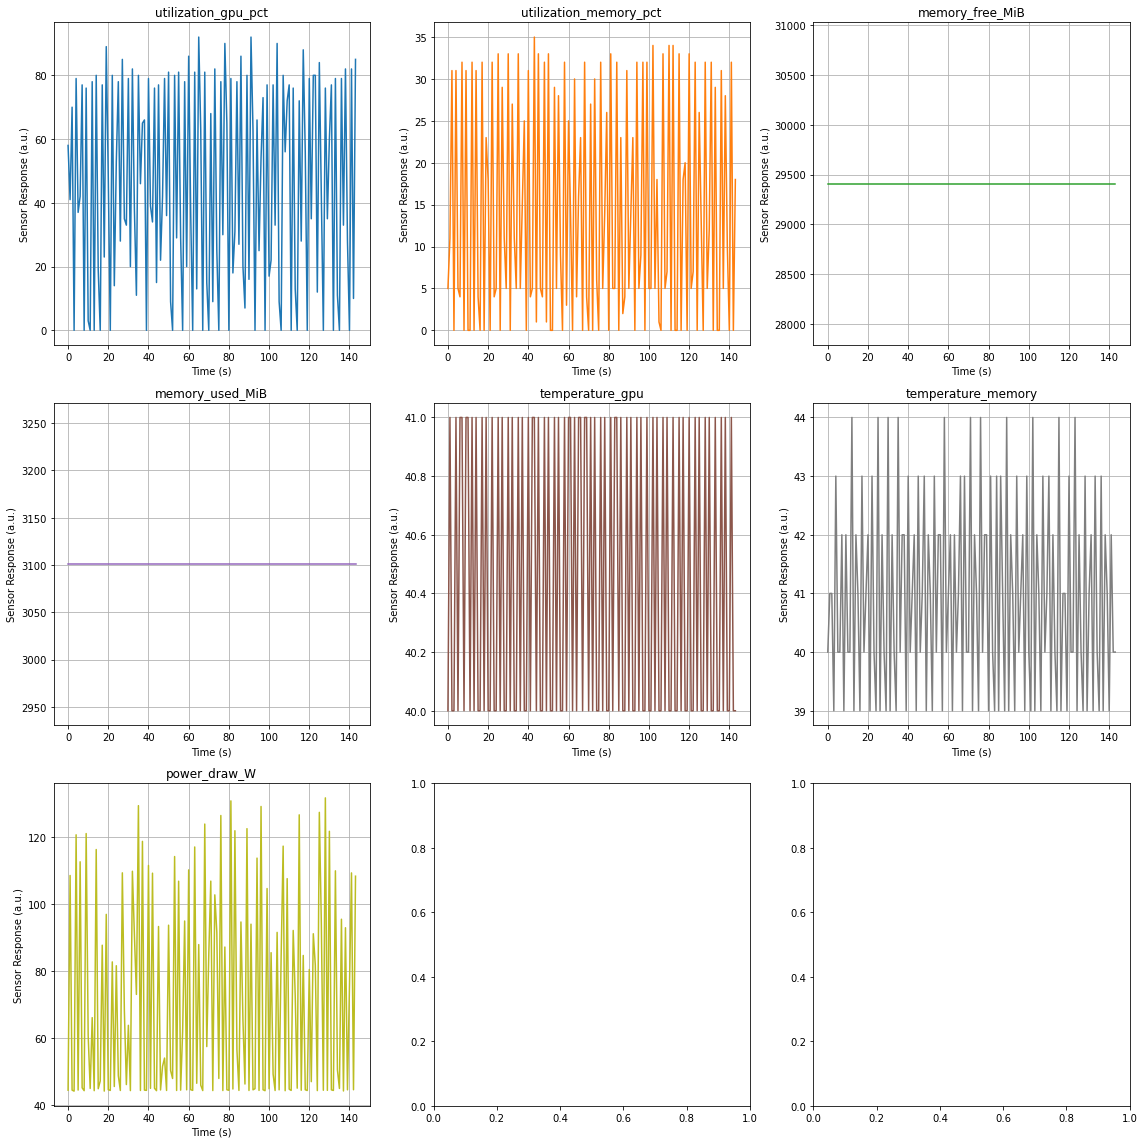

In [8]:
# parameters
trial = 0
downsample = 5
n_sensors = X.shape[-1]

# colors
cm = plt.get_cmap('tab10')
num_colors = n_sensors
colors = [cm(1.*i/num_colors) for i in range(num_colors)]

# figure
fig, axs = plt.subplots(3,3,figsize=(16,16))

# loop over columns to plot
for ax,sensor,color in zip(axs.ravel(),np.arange(n_sensors),colors):
    ax.plot(X[trial,:,sensor][::downsample],color=color)
    ax.set_title(gpu_features[sensor])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Sensor Response (a.u.)')
    ax.grid()
fig.tight_layout()
plt.show()
plt.close()